# Prepare some things
## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.utils import to_categorical

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics
from scipy.cluster import hierarchy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../../')
from models import get_autoencoder_model, get_dec_model, get_vade_models, compute_p, compute_delta
from clustering_metrics import evaluate_clustering
from draw_embeddings import draw_multiple_labels

In [3]:
# Disable warnings output (TSNE outputs one very time)
import warnings
warnings.filterwarnings('ignore')

## Load the exposome data

Already corrected for the batch effect, and min-max normalized.

In [4]:
exposome = pd.read_csv("../ExposomeChallengeData/datasets/exposome_corrected_minmax.csv", index_col=0).iloc[:,1:]
exposome.head()

,h_no2_ratio_preg_Log,h_pm10_ratio_preg_None,h_pm25_ratio_preg_None,hs_no2_dy_hs_h_Log,hs_no2_wk_hs_h_Log,hs_no2_yr_hs_h_Log,hs_pm10_dy_hs_h_None,hs_pm10_wk_hs_h_None,hs_pm10_yr_hs_h_None,hs_pm25_dy_hs_h_None,...,hs_globalexp2_None,hs_smk_parents_None,h_distinvnear1_preg_Log,h_trafload_preg_pow1over3,h_trafnear_preg_pow1over3,hs_trafload_h_pow1over3,hs_trafnear_h_pow1over3,h_bro_preg_Log,h_clf_preg_Log,h_thm_preg_Log
1,0.416136,0.444786,0.497391,0.618106,0.442270,0.594844,0.279071,0.275210,0.306145,0.296258,...,0.807087,0.499567,0.400776,0.211466,0.350886,0.468451,0.394203,0.482458,0.598862,0.249862
2,0.495063,0.442465,0.575386,0.465155,0.466713,0.655715,0.221738,0.330068,0.301455,0.201571,...,0.185984,0.043001,0.456994,0.211466,0.388829,0.316925,0.461888,0.482458,0.750712,0.453235
3,0.551118,0.451135,0.593489,0.707666,0.445262,0.490263,0.443946,0.345879,0.183539,0.484234,...,0.185984,0.271284,0.538060,0.575146,0.465464,0.434817,0.493450,0.606040,0.761052,0.441235
4,0.518867,0.273590,0.414957,0.529180,0.571649,0.691260,0.435828,0.380171,0.359060,0.188234,...,0.962733,0.290828,0.609293,0.856349,0.589776,0.453020,0.537590,0.653920,0.859000,0.468049
5,0.523168,0.595750,0.474000,0.572407,0.471369,0.585228,0.319829,0.306791,0.207039,0.297050,...,0.205884,0.044110,0.608198,0.499261,0.499729,0.597159,0.163098,0.564723,0.771555,0.325027


In [5]:
exposome = exposome.to_numpy()
print("Shape of the data set:", exposome.shape)
print("Number of data points:", exposome.flatten().shape[0])

Shape of the data set: (1152, 221)
Number of data points: 254592


## Load the categorical variables
(subset of phenotype and covariates data, already codified)

In [6]:
phenotype_cat = pd.read_csv("../ExposomeChallengeData/datasets/phenotype_cat.csv", index_col=0)
covariates_cat = pd.read_csv("../ExposomeChallengeData/datasets/covariates_cat.csv", index_col=0)
classes = pd.concat([phenotype_cat, covariates_cat], axis=1)
classes.head()

,birth_weight,iq,behaviour,asthma,bmi,cohort,age,sex,education,native,parity
1,3,0,3,0,1,3,1,0,1,2,0
2,3,1,3,0,1,3,2,0,2,2,1
3,3,0,3,1,3,3,1,0,2,2,1
4,1,2,3,0,1,1,4,1,0,2,1
5,3,0,1,0,1,2,4,0,0,2,0


In [7]:
print("Number of class variables:", classes.shape[1])

Number of class variables: 11


# Deep clustering models

In [8]:
categorical_variables = {2: ["asthma", "sex"],
                         3: ["education", "native", "parity"],
                         4: ["birth_weight", "iq", "behaviour", "bmi"],
                         6: ["cohort"],
                         7: ["age"]}

true_labels = {}
for k, variables in categorical_variables.items():
    true_labels[k] = {var: classes.loc[:,var] for var in variables}

cluster_labels = []
results = []

## DEC

In [9]:
INPUT_DIM = exposome.shape[1]  # 221
INTERMEDIATE_DIMS = (16, 16, 128)

EPOCHS_PRETRAIN = 50
LEARNING_RATE_PRETRAIN = 1
MOMENTUM_PRETRAIN = 0.9

EPOCHS_FINETUNE = 100
LEARNING_RATE_FINETUNE = 1e-4
MOMENTUM_FINETUNE = 0.9

BATCH_SIZE = 32
SCHEDULE = 10
DELTA_THRESHOLD = 0.001

In [10]:
def dec_callback(epoch, logs):
    global p
    global c_last
    
    if (epoch+1) % SCHEDULE == 0:
        q = model_dec.soft_assignment(exposome)
        p = compute_p(q)
        
        c_new = q.numpy().argmax(1)
        delta = compute_delta(c_new, c_last)
        c_last = np.copy(c_new)
        # print(f"Delta: {delta:.3f}")
        if (delta < DELTA_THRESHOLD):
            model_dec.stop_training = True
            
callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=dec_callback)

K=2 - Pretraining AE [loss: 0.0230] - Fine-tunning DEC [loss: 1.5046]
asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.683']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.683']
K=3 - Pretraining AE [loss: 0.0230] - Fine-tunning DEC [loss: 3.4007]
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.662']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.662']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.662']
K=4 - Pretraining AE [loss: 0.0232] - Fine-tunning DEC [loss: 5.6801]
birth_weight ['Acc: 0.284', 'ARI: 0.002', 'AMI: 0.001', 'Sil: 0.630']
iq ['Acc: 0.302', 'ARI: 0.006', 'AMI: 0.003', 'Sil: 0.630']
behaviour ['Acc: 0.296', 'ARI: 0.004', 'AMI: 0.004', 'Sil: 0.630']
bmi ['Acc: 0.694', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.630']
K=6 - Pretraining AE [loss: 0.0232] - Fine-tunning DEC [loss: 8.0292]
cohort ['Acc: 0.219', 'ARI: 0.004', 'AMI: 0.005', 'Sil: 0.550']
K=7 - Pretraining AE [loss: 0.0230] - Fine-tunning DEC [loss: 9.2262]
age ['Ac

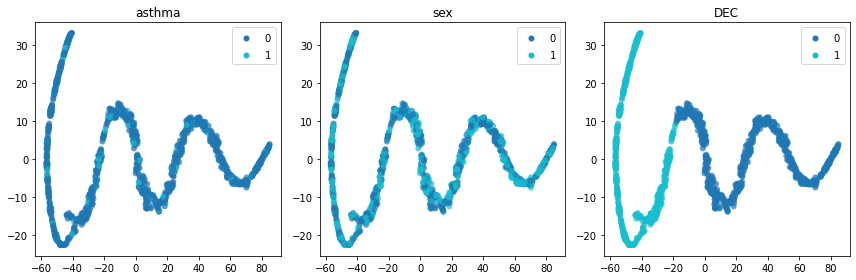

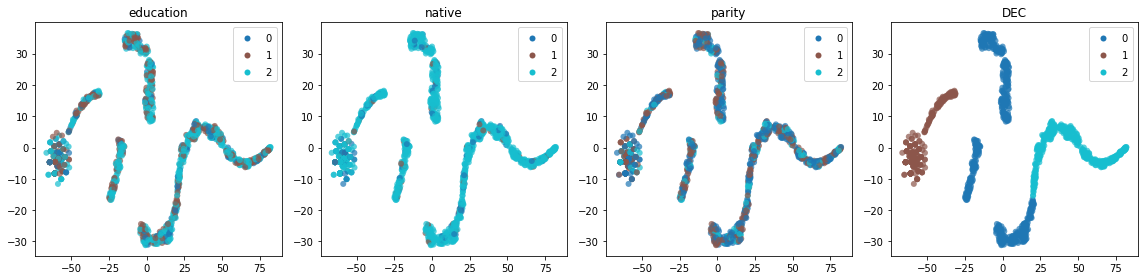

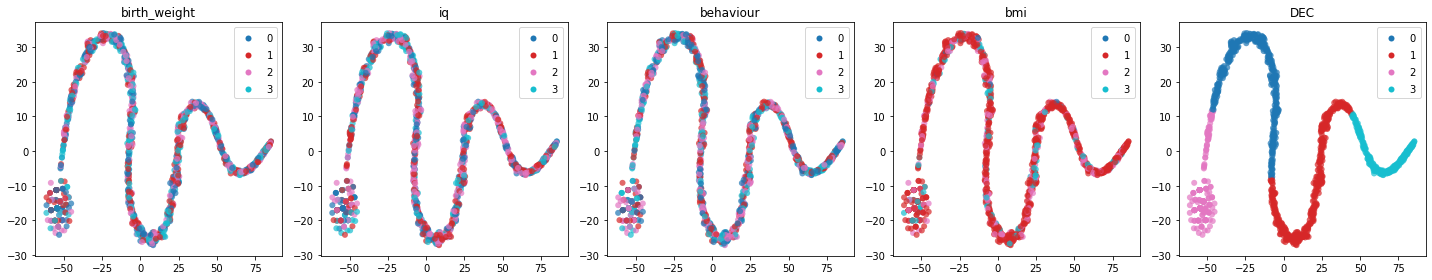

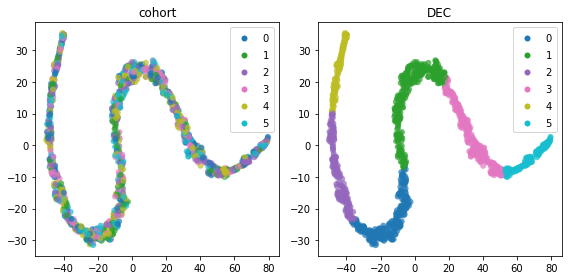

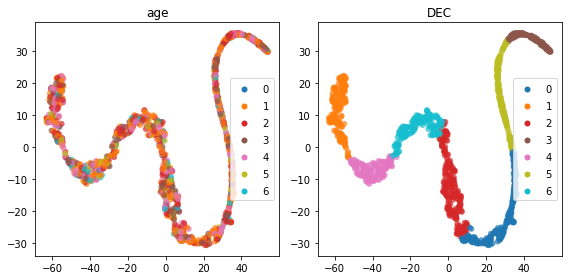

In [11]:
rl_method = "DEC"
clust_method = "K-Means"
data = exposome

for k, variables in categorical_variables.items():
    LATENT_DIM = k
    N_CLUSTERS = k
    
    # Construct and pretrain AE
    print(f"K={k} - Pretraining AE", end=" ")
    model_ae = get_autoencoder_model(INPUT_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PRETRAIN,
                                     momentum=MOMENTUM_PRETRAIN)
    loss = "mse"
    model_ae.compile(optimizer=optimizer, loss=loss)
    history = model_ae.fit(data, data,
                           epochs=EPOCHS_PRETRAIN,
                           batch_size=BATCH_SIZE,
                           verbose=0)
    print(f"[loss: {history.history['loss'][-1]:.4f}]", end=" ")
    
    # Construct DEC
    print("- Fine-tunning DEC", end=" ")
    model_dec = get_dec_model(model_ae.encoder, N_CLUSTERS)
    
    # Initialize parameters
    z_dec = model_dec.encode(data)
    kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
    kmeans.fit(z_dec)
    for weight in model_dec.trainable_weights:
        if weight.name == "centroids:0":
            weight.assign(K.constant(kmeans.cluster_centers_))

    p = compute_p(to_categorical(kmeans.labels_))
    c_last = kmeans.labels_

    # Fine-tune the model
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_FINETUNE, 
                                     momentum=MOMENTUM_FINETUNE)
    model_dec.compile(optimizer=optimizer)
    history = model_dec.fit(data, p,
                            epochs=EPOCHS_FINETUNE,
                            batch_size=BATCH_SIZE,
                            callbacks = callback,
                            verbose=0)
    print(f"[loss: {history.history['loss'][-1]:.4f}]")
    
    # Compute the cluster assignments
    c_dec = model_dec.classify(data)
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": c_dec})
    
    # Compute metrics
    z_dec = model_dec.encode(data)
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(z_dec, labels, c_dec, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)
    
    # Draw the embeddings
    tsne = TSNE(n_components=2, init='pca')
    z_dec_tsne = tsne.fit_transform(z_dec)

    labels = true_labels[k].copy()
    labels.update({rl_method: c_dec})
    draw_multiple_labels(z_dec_tsne, labels)

## VaDE

(Not evaluated becuase I can't make it fit relliably, I keep getting loss=NaN most of the times...)

In [12]:
INPUT_DIM = exposome.shape[1]  # 221
INTERMEDIATE_DIMS = (16, 16, 128)

EPOCHS_PRETRAIN = 20
LEARNING_RATE_PRETRAIN = 1
MOMENTUM_PRETRAIN = 0.8

EPOCHS_FINETUNE = 50
LEARNING_RATE_FINETUNE = 1e-5
MOMENTUM_FINETUNE = 0.8

BATCH_SIZE = 32
SCHEDULE = 10

In [13]:
def scheduler(epoch, lr):
    if (epoch+1) % SCHEDULE == 0:
        lr = lr * 0.9
    return lr

callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),]

In [14]:
# rl_method = "VaDE"
# clust_method = "GMM"
# data = exposome

# for k, variables in categorical_variables.items():
#     LATENT_DIM = k
#     N_CLUSTERS = k
    
#     # Construct and train the VaDE model.
#     # If loss == NaN: retry.
#     while True:
#         # Construct models and pretrain AE
#         print(f"K={k} - Pretraining AE", end=" ")
#         model_pretrain, model_vade = get_vade_models(N_CLUSTERS, INPUT_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
#         optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PRETRAIN,
#                                          momentum=MOMENTUM_PRETRAIN)
#         loss = keras.losses.BinaryCrossentropy()
#         model_pretrain.compile(optimizer=optimizer, loss=loss)
#         history = model_pretrain.fit(data,
#                                      epochs=EPOCHS_PRETRAIN,
#                                      batch_size=BATCH_SIZE,
#                                      verbose=0)
#         print(f"[loss: {history.history['loss'][-1]:.4f}]", end=" ")

#         # Initialize parameters
#         z_vade = model_vade.encode_only_mu(data)
#         gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag', n_init=30)
#         gmm.fit(z_vade)
#         for weight in model_vade.trainable_weights:
#             if weight.name == "pi:0":
#                 weight.assign(K.log(K.constant(gmm.weights_)))
#             elif weight.name == "mu:0":
#                 weight.assign(K.constant(gmm.means_))
#             elif weight.name == "logvar:0":
#                 weight.assign(K.log(K.constant(gmm.covariances_)))

#         # Fine-tune the model
#         print("- Fine-tunning VaDE", end=" ")
#         optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_FINETUNE,
#                                          momentum=MOMENTUM_FINETUNE)
#         model_vade.compile(optimizer=optimizer)
#         history = model_vade.fit(data,
#                                  epochs=EPOCHS_FINETUNE,
#                                  batch_size=BATCH_SIZE,
#                                  callbacks = callback,
#                                  verbose=0)
#         #If loss == NaN: retry.
#         if np.isnan(history.history['loss'][-1]):
#             print("[loss: NaN. Retrying.]")
#             continue
#         else:
#             print(f"[loss: {history.history['loss'][-1]:.4f}]")
#             break

#     # Compute the cluster assignments
#     c_vade = model_vade.classify(data).numpy()
#     cluster_labels.append({"rl_method": rl_method, 
#                            "clust_method": clust_method, 
#                            "n_clusters": k, 
#                            "labels": c_vade})
    
#     # Compute metrics
#     z_vade = model_vade.encode_only_mu(data)
#     for variable, labels in true_labels[k].items():
#         metrics = evaluate_clustering(z_vade, labels, c_vade, False)
#         print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
#         result = {"rl_method": rl_method, 
#                   "clust_method": clust_method, 
#                   "n_clusters": k, 
#                   "variable": variable}
#         result.update(metrics)
#         results.append(result)
    
#     # Draw the embeddings
#     tsne = TSNE(n_components=2, init='pca')
#     z_vade_tsne = tsne.fit_transform(z_vade)

#     labels = true_labels[k].copy()
#     labels.update({rl_method: c_vade})
#     draw_multiple_labels(z_vade_tsne, labels)

# Results

## Metrics

In [15]:
results = pd.DataFrame(results)
# Save the metrics on a CSV file
results.to_csv("results/metrics_deepclust.csv", index=False)

results_mean = results.set_index(["rl_method","clust_method"]).groupby(level=[0,1]).mean()
results_mean = results_mean.iloc[:,1:]
results_mean.style.background_gradient(axis=0, cmap="cividis", text_color_threshold=0.3, subset=['Acc','ARI','AMI','Sil']).format('{:.2f}', subset=['Acc','ARI','AMI','Sil'])

,,Acc,ARI,AMI,Sil
rl_method,clust_method,,,,
DEC,K-Means,0.49,0.00,0.00,0.63


In [16]:
results.style.background_gradient(axis=0, cmap="cividis", text_color_threshold=0.3, subset=['Acc','ARI','AMI','Sil']).format('{:.2f}', subset=['Acc','ARI','AMI','Sil'])

,rl_method,clust_method,n_clusters,variable,Acc,ARI,AMI,Sil
0,DEC,K-Means,2,asthma,0.89,0.00,0.00,0.68
1,DEC,K-Means,2,sex,0.53,0.00,0.00,0.68
2,DEC,K-Means,3,education,0.51,0.00,0.00,0.66
3,DEC,K-Means,3,native,0.84,0.00,0.00,0.66
4,DEC,K-Means,3,parity,0.45,0.00,0.00,0.66
5,DEC,K-Means,4,birth_weight,0.28,0.00,0.00,0.63
6,DEC,K-Means,4,iq,0.30,0.01,0.00,0.63
7,DEC,K-Means,4,behaviour,0.30,0.00,0.00,0.63
8,DEC,K-Means,4,bmi,0.69,0.00,0.00,0.63
9,DEC,K-Means,6,cohort,0.22,0.00,0.00,0.55


## Compare assignments

In [17]:
cluster_labels = pd.DataFrame(cluster_labels)

# Save the assignments on a CSV file
pd.DataFrame(cluster_labels).to_csv("results/assign_deepclust.csv", index=False)

In [18]:
# for k in categorical_variables.keys():
#     clusters = cluster_labels[cluster_labels.n_clusters==k]
#     labels = {clusters.rl_method[i]: clusters.labels[i] for i in clusters.index}
#     draw_multiple_labels(z_vade_tsne, labels, max_cols=6)

    # metrics = evaluate_clustering(z_vade_tsne, labels["DEC"], labels["VaDE"], False)
    # print(f'DEC vs VaDE - K={k}', [f'{metric}: {value:.3f}' for metric, value in metrics.items()])